<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/acs_income/acs_income_sampling/acs_income_sex_notebook/acs_income_sex_1k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>This Notebook will contain some of the final steps taken with the ACS Income Dataset<h3>
<h4>There are a number of steps that I will be taking here to see the solution across multiple samples of ACSincome data<h4>
<ul>
<li>Take 5 samples of the ACSIncome data: 1k, 5k, 10k, 15k, 20k</li>
<li>Flip 20% of the datapoints rather than 50%</li>
<li>Represent the changes as percentages rather than individual datapoints</li>
<li>This file will also contain all the sensitive attributes in order see them against each other</li>
</ul>

In [14]:
#!pip install folktables

In [15]:
#Import all of the necessary libraries in
import pandas as pd
import numpy as np
np.float = float
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from folktables import ACSDataSource, ACSIncome
import math
import time
warnings.filterwarnings('ignore')

In [16]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on

def s_parity(test_data, predictors, prediction_df, sensitive_attr, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: outcome
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]==0]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]==1]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 0)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 1)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [17]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [ ]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression_updated(train_dataset, X_test_orig, y_test, independent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        training_labels = train_dataset.pop('PINCP')
        training_attributes = train_dataset
        #x = train_dataset[independent_var].values
        #y = train_dataset[dependent_var].values
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(training_attributes,training_labels)
        prediction = log.predict(X_test_orig)

        train_dataset['PINCP'] = training_labels
        #print(train_dataset)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(X_test_orig, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

<h5>Setup the data with the random samples from acs_income.csv<h5>

In [18]:
#Split the data into different dataframes to represent the samples

#1k datpoints
tenk_datapoints = pd.read_csv('acs_income.csv', index_col=None, sep=',').sample(10000)
tenk_datapoints=tenk_datapoints.reset_index(drop=True)

<h5>Code all the datapoints to make it look nicer<h5>

In [19]:
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

tenk_datapoints['SCHL'] = tenk_datapoints['SCHL'].apply(assign_group)

In [20]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
tenk_datapoints['OCCP'] = tenk_datapoints['OCCP'].apply(assign_group)

In [21]:
#Add family codes
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
tenk_datapoints['RELP'] = tenk_datapoints['RELP'].apply(assign_group)

In [22]:
#Code the Class of worker column from numeric to strings
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(1, 'private_business')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(2, 'non-profit')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(3, 'local_gov')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(4, 'state_gov')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(5, 'federal_gov')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(6, 'SE_no_business')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(7, 'SE_business')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(8, 'no_pay_work')
tenk_datapoints['COW'] = tenk_datapoints['COW'].replace(9, 'unemployed')


In [23]:
#Class the Marital Status from numeric to strings
tenk_datapoints['MAR'] = tenk_datapoints['MAR'].replace(1, 'married')
tenk_datapoints['MAR'] = tenk_datapoints['MAR'].replace(2, 'widowed')
tenk_datapoints['MAR'] = tenk_datapoints['MAR'].replace(3, 'divorced')
tenk_datapoints['MAR'] = tenk_datapoints['MAR'].replace(4, 'seperated')
tenk_datapoints['MAR'] = tenk_datapoints['MAR'].replace(5, 'never_married')

In [24]:
#Add Age codes 
#young and old
ranges = {
    'young': (0,45),
    'old': (46,99),
}
group_dict = {}
tenk_datapoints['AGEP'] = tenk_datapoints['AGEP'].apply(assign_group)

In [25]:
#Code the PINCP column so that it is binary
ranges = {
    0: (0,50000),
    1: (50001,2000000)
}
group_dict = {}
tenk_datapoints['PINCP'] = tenk_datapoints['PINCP'].apply(assign_group)

In [26]:
tenk_datapoints = tenk_datapoints.drop(columns=['RAC1P','SEX'])

In [27]:
encoded_data = pd.get_dummies(tenk_datapoints, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','AGEP','ST'])

<h5>After Coding each of the different columns, now I will get original parity and accuracy<h5>

In [28]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

77.7


In [29]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['AGEP_old']==0]))
total_priv = (len(concat_df[concat_df['AGEP_old']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['AGEP_old'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['AGEP_old'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.25092


<h5>Iterative Flipping<h5>

In [30]:
#Need to build a new dataframe for training and testing purposes for iterative flipping
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

start = time.time()

In [31]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [32]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df, x_test, y_test, predictors, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df, x_test, y_test, predictors, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [33]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [34]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [35]:
#Flip the top 50% of the list
sorted_indices_list = sorted_indices_list[:int(len(sorted_indices_list)*.2)]

In [36]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
iterative_ranked_parity = []
#Accuracy after every flip
iterative_ranked_acc = []
#Index/row of the flip
iterative_ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df, x_test, y_test, predictors, 'income')

      iterative_ranked_flip.append(row_num)
      iterative_ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
      iterative_ranked_parity.append(parity)


  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df, x_test, y_test, predictors, 'income')

      iterative_ranked_flip.append(row_num)
      iterative_ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
      iterative_ranked_parity.append(parity)

In [37]:
#Place the original parity at the beginning of the list
iterative_ranked_parity.insert(0,statistical_parity)

In [38]:
#Store end time
end = time.time()
total_time = end-start

time_taken = []
solution = []

time_taken.append(total_time)
solution.append('Iterative Flipping')

<h5>Uncertainty Reduction<h5>

In [39]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

start = time.time()

In [40]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [41]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [42]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [43]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [44]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Getting the top 50% values
ranked_indices_list = ranked_indices_list[:int(len(ranked_indices_list)*.2)]

In [45]:
#After ranking and getting the top 50% points I flip them based on where they are in the list

#Different lists to hold each of the values
entropy_ranked_parity = [statistical_parity]
entropy_ranked_acc = []
entropy_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df_entropy, x_test, y_test, predictors, 'income')

    entropy_ranked_flip.append(row_num)
    entropy_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old','income')
    entropy_ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df_entropy, x_test, y_test, predictors, 'income')

    entropy_ranked_flip.append(row_num)
    entropy_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old','income')
    entropy_ranked_parity.append(parity)


end = time.time()
total_time = end - start

In [46]:
time_taken.append(total_time)
solution.append('Uncertainty Reduction')

<h5>Maximum Expected Utility<h5>`

In [47]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

start = time.time()

In [48]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [49]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [50]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [51]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [52]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 0:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [53]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression_updated(copy_train_full_df, x_test, y_test, predictors, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression_updated(copy_train_full_df, x_test, y_test, predictors, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [54]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 0:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [55]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [56]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [57]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

#Get the top 20% of points
sorted_index_list = sorted_index_list[:int(len(sorted_index_list)*.2)]

In [58]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df_MEU, x_test, y_test, predictors, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression_updated(train_full_df_MEU, x_test, y_test, predictors, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
    MEU_ranked_parity.append(parity)




In [59]:
#Convert each of the tuples into lists
meu_ranked_indices_list = list(sorted_index_list)
meu_ranked_eu_list = list(MEU_ranked_parity)

#Time Taken
end = time.time()
total_time = end - start

time_taken.append(total_time)
solution.append('MEU')

<h5>Random Flipping<h5>

In [60]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

start = time.time()

In [61]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [62]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression_updated(train_full_df_random, x_test, y_test, predictors, 'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old','income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression_updated(train_full_df_random, x_test, y_test, predictors, 'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'AGEP_old', 'income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




In [63]:
end = time.time()

total_time = end - start
time_taken.append(total_time)
solution.append('Random Flipping')

<h4>Graph the changes in parity for 1k datapoints<h4>

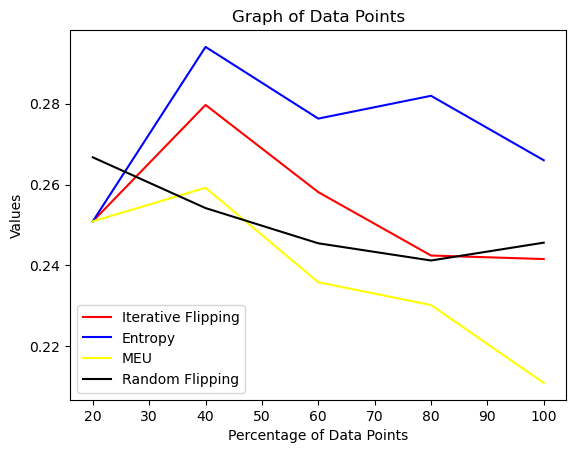

In [64]:
# Calculate the total number of data points
datapoints_iterative = len(iterative_ranked_parity)
datapoints_entropy = len(entropy_ranked_parity)
datapoints_meu = len(meu_ranked_eu_list)
datapoints_random = len(random_list_parity)

# Calculate the indices for the 5 points
indices_iterative = [int(i * datapoints_iterative / 5) for i in range(0, 5)]
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_meu = [int(i * datapoints_meu / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]

# Extract the values at these indices
values_iterative = [iterative_ranked_parity[index] for index in indices_iterative]
values_entropy = [entropy_ranked_parity[index] for index in indices_entropy]
values_meu = [meu_ranked_eu_list[index] for index in indices_meu]
values_random = [random_list_parity[index] for index in indices_random]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_iterative, label='Iterative Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_meu, label='MEU', color='Yellow')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

In [65]:
time_taken

[2484.642261505127, 401.2457926273346, 2646.7729785442352, 468.64172649383545]